## Import Library

In [ ]:
import pandas as pd
import numpy as np
print(pd.__version__)
print(np.__version__)

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
from IPython.display import Image
from scipy import stats

1.3.5
1.21.6


## 1. Business Understanding

Problem :

- Mizan Amanah memiliki beberapa donatur dengan berbagai karakteristik dan perilaku donasi yang berbeda namun belum terbagi sesuai segmentasi
- Belum terdapat sistem reporting yang dapat mengetahui program dengan donasi terbanyak, jumlah donasi yang diterima dalam periode waktu tertentu, donatur guest yang berpotensi menjadi register, metode pembayaran, dan sebagainya

Tujuan :
1. Melakukan segmentasi donatur Mizan Amanah dengan metode RFM
2. Menentukan targeted propensity model untuk memprediksi perilaku donatur Mizan Amanah
3. Membuat dashboard/reporting interaktif untuk memudahkan Mizan Amanah dalam melakukan analisis terhadap donatur dan program donasi yang ada

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Data Understanding

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Internship/Dataset Mizan/donasi_online_MA_guests.csv')
data.head()

,tanggal,id_transaksi,donor_id,type_donor,nominal,akad,program,payment
0,2022-08-01 10:41:37.0,52048,G16135,guest,100000,Pendidikan,orang_tua_asuh_yatim_penghafal_quran,bank_transfer
1,2022-08-01 09:48:11.0,52047,G20673,guest,250000,Pendidikan,SERAGAM SEKOLAH UNTUK YATIM DHUAFA,bank_transfer
2,2022-08-01 09:45:29.0,52046,G20673,guest,500000,Infaq Sedekah,Berkah Dengan Sedekah,bank_transfer
3,2022-08-01 09:28:41.0,52044,G20671,guest,300000,Zakat,Zakat Penghasilan,DANA
4,2022-08-01 09:21:28.0,52043,G17793,guest,500000,Zakat,Zakat Penghasilan,bank_transfer


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7489 entries, 0 to 7488
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tanggal       7489 non-null   object
 1   id_transaksi  7489 non-null   int64 
 2   donor_id      7489 non-null   object
 3   type_donor    7489 non-null   object
 4   nominal       7489 non-null   int64 
 5   akad          7489 non-null   object
 6   program       7489 non-null   object
 7   payment       7489 non-null   object
dtypes: int64(2), object(6)
memory usage: 468.2+ KB


In [ ]:
data.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
id_transaksi,7489.0,34933.304447,15778.873671,2702.0,31145.0,40723.0,46213.0,52048.0
nominal,7489.0,211186.366538,667961.418130,750.0,35000.0,100000.0,200000.0,30000000.0


In [ ]:
data.describe(include='object').T

,count,unique,top,freq
tanggal,7489,7469,2022-05-02 05:49:10.0,2
donor_id,7489,4622,G15314,210
type_donor,7489,1,guest,7489
akad,7489,16,Infaq Sedekah,1249
program,7489,158,Zakat Fitrah,1029
payment,7489,23,bank_transfer,3371


### 2.1 Data Cleaning

In [ ]:
# Melakukan pengecekan terhadap missing value
percent_na = round((data.isna().sum()/len(data))*100, 2)
percent_na

tanggal         0.0
id_transaksi    0.0
donor_id        0.0
type_donor      0.0
nominal         0.0
akad            0.0
program         0.0
payment         0.0
dtype: float64

In [ ]:
# Melakukan pengecekan terhadap data duplikat

data[data.duplicated(keep=False)]

,tanggal,id_transaksi,donor_id,type_donor,nominal,akad,program,payment


In [ ]:
data.nunique().sort_values(ascending=False)

id_transaksi    7489
tanggal         7469
donor_id        4622
nominal          578
program          158
payment           23
akad              16
type_donor         1
dtype: int64

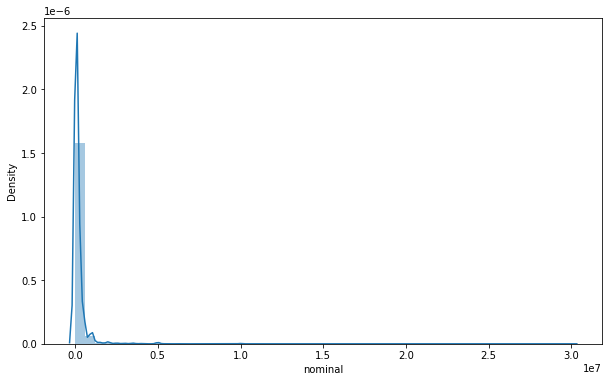

In [ ]:
# Melakukan pengecekan terhadap outlier
plt.figure(figsize = (10,6))
sns.distplot(data['nominal'])

In [ ]:
mean = data['nominal'].mean()
std = data['nominal'].std()

In [ ]:
limit = 3*std

In [ ]:
upper = mean + 3*std
lower = mean - 3*std

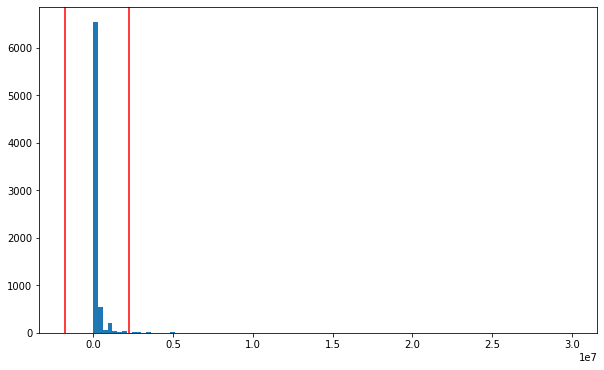

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(data['nominal'], bins = 100)

ax.axvline(upper, color = 'r')
ax.axvline(lower, color = 'r')
plt.show()

In [ ]:
# Cek data outlier di lower limit
(data['nominal'] < lower).sum()

0

In [ ]:
# Cek data outlier di upper limit
(data['nominal'] > upper).sum()

77

In [ ]:
# Data without outliers
data = data[(data['nominal'] > lower) & (data['nominal'] < upper)]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7412 entries, 0 to 7488
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tanggal       7412 non-null   object
 1   id_transaksi  7412 non-null   int64 
 2   donor_id      7412 non-null   object
 3   type_donor    7412 non-null   object
 4   nominal       7412 non-null   int64 
 5   akad          7412 non-null   object
 6   program       7412 non-null   object
 7   payment       7412 non-null   object
dtypes: int64(2), object(6)
memory usage: 521.2+ KB


In [ ]:
data['payment'].value_counts()

bank_transfer                                 3337
gopay                                         1105
MANDIRI                                        948
BNI                                            569
BRI                                            332
DANA                                           254
OVO                                            218
Transfer Bank Mandiri Syariah - 7277777775     159
LINKAJA                                        120
SHOPEEPAY                                      108
PERMATA                                         68
echannel                                        58
Transfer Bank Mandiri - 1320505050535           42
Transfer Bank Mandiri Syariah - 7273737377      32
credit_card                                     22
ALFAMART                                        20
bca_va                                          10
akulaku                                          3
Transfer Bank BCA Gani - 2332438027              3
BJB                            

In [ ]:
# Melakukan pengelompokkan tipe payment
data['payment'] = data['payment'].replace(['MANDIRI', 'BNI', 'BRI', 'Transfer Bank Mandiri Syariah - 7277777775',
                                      'PERMATA', 'Transfer Bank Mandiri - 1320505050535','Transfer Bank Mandiri Syariah - 7273737377',
                                       'bca_va', 'Transfer Bank BCA Gani - 2332438027', 'BJB','BSI',
                                       'bni_va','Transfer Bank Mandiri - 1320505050519'],                                
                                      ['bank_transfer', 'bank_transfer', 'bank_transfer','bank_transfer',
                                      'bank_transfer', 'bank_transfer', 'bank_transfer','bank_transfer',
                                      'bank_transfer', 'bank_transfer', 'bank_transfer','bank_transfer',
                                      'bank_transfer'])

In [ ]:
data['payment'].value_counts()

bank_transfer    5504
gopay            1105
DANA              254
OVO               218
LINKAJA           120
SHOPEEPAY         108
echannel           58
credit_card        22
ALFAMART           20
akulaku             3
Name: payment, dtype: int64

### 2.2 EDA

In [ ]:
EDA_data = data.copy()

                                                    id_transaksi
program                                                         
Zakat Fitrah                                                1029
Zakat Penghasilan                                            713
Berkah Dengan Sedekah                                        580
Infaq Sedekah / Ramadhan                                     534
ZAKAT DI MIZAN AMANAH                                        392
...                                                          ...
Mushola Seperti Gubuk Reyot di Kampung Laut, Ingin             1
Bantu Asep Irawan                                              1
Salaing Jaga Untuk Sesama                                      1
Sedekah Bantu Lansia Dhuafa Jalani Sisa Hidup Yang             1
Bantu Adinda Salma Sembuh, Mengidap Hidrosefalus P             1

[157 rows x 1 columns]


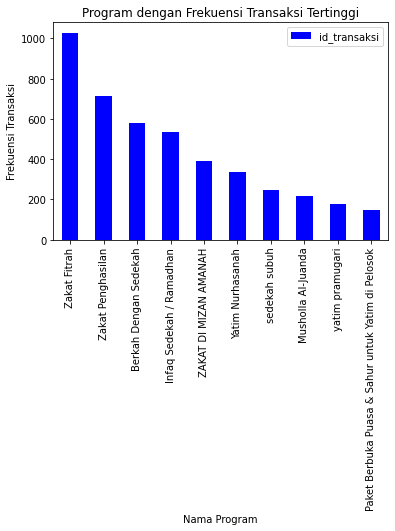

In [ ]:
# Program dengan frekuensi transaksi tertinggi
print(EDA_data.groupby('program')['id_transaksi'].count().sort_values(ascending=False).to_frame())
EDA_data.groupby('program')['id_transaksi'].count().sort_values(ascending=False).to_frame().head(10).plot( kind='bar',
                                                                                                        title='Program dengan Frekuensi Transaksi Tertinggi',
                                                                                                        xlabel='Nama Program',
                                                                                                        ylabel='Frekuensi Transaksi',
                                                                                                        color='blue'
                                                                                                        )
plt.show()

                    id_transaksi
akad                            
Infaq Sedekah               1241
Panti Asuhan                1094
Zakat Fitrah                1029
Ramadhan                     992
Zakat                        894
Pendidikan                   857
Kemanusiaan                  329
Zakat Penghasilan            320
Wakaf                        318
Dakwah                       241
Kesehatan                     37
Zakat Harta (Maal)            31
Ekonomi                       10
Zakat Harta                    9
Zakat Emas                     5
Zakat Uang                     5


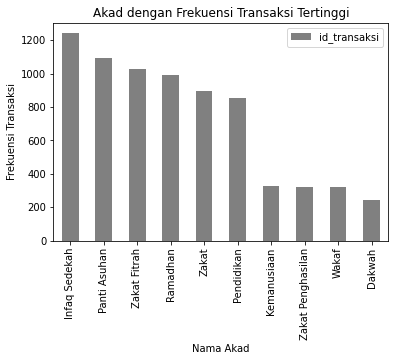

In [ ]:
# Akad dengan frekuensi transaksi tertinggi
print(EDA_data.groupby('akad')['id_transaksi'].count().sort_values(ascending=False).to_frame())
EDA_data.groupby('akad')['id_transaksi'].count().sort_values(ascending=False).to_frame().head(10).plot( kind='bar',
                                                                                                        title='Akad dengan Frekuensi Transaksi Tertinggi',
                                                                                                        xlabel='Nama Akad',
                                                                                                        ylabel='Frekuensi Transaksi',
                                                                                                        color='gray'
                                                                                                        )
plt.show()

                                                      nominal
program                                                      
Zakat Penghasilan                                   221710552
Berkah Dengan Sedekah                               104893605
Infaq Sedekah / Ramadhan                             88807006
Zakat Fitrah                                         83046265
ZAKAT DI MIZAN AMANAH                                45345212
...                                                       ...
Berbagi Kebahagiaan Alat Tulis Untuk Yatim              20000
Donasi Bencana, Bantu Warga Cicurug Bangkit Setela      20000
Sedekah Bantu Lansia Dhuafa Jalani Sisa Hidup Yang      20000
Ludes Dilahap si Jago Merah, Yuk, Patungan Bangun       10000
Bantu Korban Angin Puting Beliung                        5000

[157 rows x 1 columns]


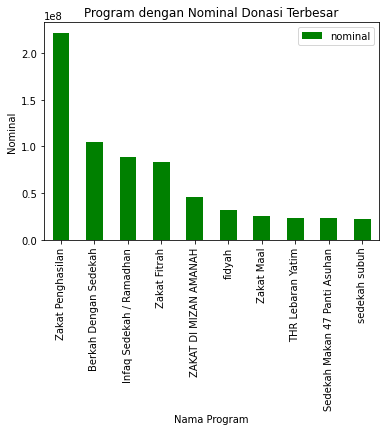

In [ ]:
# Program dengan nominal terbesar
print(EDA_data.groupby('program')['nominal'].sum().sort_values(ascending=False).to_frame())
EDA_data.groupby('program')['nominal'].sum().sort_values(ascending=False).to_frame().head(10).plot(kind='bar',
                                                                                                 title='Program dengan Nominal Donasi Terbesar',
                                                                                                 xlabel='Nama Program',
                                                                                                 ylabel='Nominal',
                                                                                                 color ='green')
plt.show()

                      nominal
akad                         
Panti Asuhan        224106144
Infaq Sedekah       210325443
Zakat               188631085
Ramadhan            172836727
Zakat Penghasilan   108381594
Zakat Fitrah         83046265
Pendidikan           62607427
Wakaf                61230517
Kemanusiaan          38100745
Zakat Harta (Maal)   21698027
Dakwah               18368481
Zakat Harta           7097083
Kesehatan             4840467
Zakat Emas            2500000
Ekonomi               1015000
Zakat Uang             997500


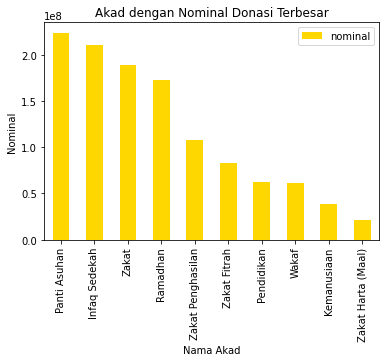

In [ ]:
# Akad dengan nominal terbesar
print(EDA_data.groupby('akad')['nominal'].sum().sort_values(ascending=False).to_frame())
EDA_data.groupby('akad')['nominal'].sum().sort_values(ascending=False).to_frame().head(10).plot( kind='bar',
                                                                                                        title='Akad dengan Nominal Donasi Terbesar',
                                                                                                        xlabel='Nama Akad',
                                                                                                        ylabel='Nominal',
                                                                                                        color='gold'
                                                                                                        )
plt.show()

bank_transfer    5504
gopay            1105
DANA              254
OVO               218
LINKAJA           120
SHOPEEPAY         108
echannel           58
credit_card        22
ALFAMART           20
akulaku             3
Name: payment, dtype: int64


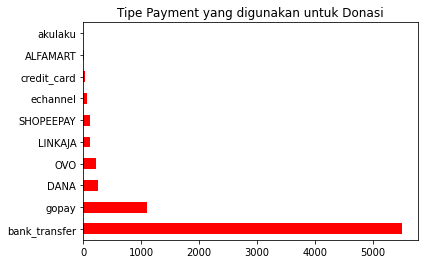

In [ ]:
# Mencari type payment yang paling banyak digunakan
print(EDA_data['payment'].value_counts())
EDA_data['payment'].value_counts().plot(kind='barh',
                                        title='Tipe Payment yang digunakan untuk Donasi',
                                        color='red')
plt.show()

In [ ]:
EDA_data['tanggal'] = pd.to_datetime(data['tanggal'])

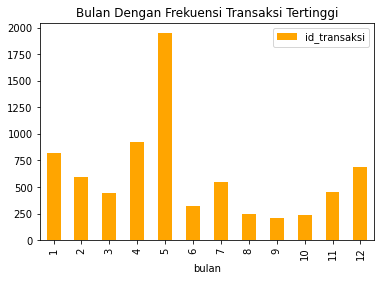

In [ ]:
# Bulan dengan frekuensi transaksi tertinggi (2021 dan 2022)
EDA_data['bulan'] = EDA_data['tanggal'].dt.month.to_frame()
EDA_data.groupby('bulan')['id_transaksi'].count().to_frame().plot(kind='bar',
                                                                  title='Bulan Dengan Frekuensi Transaksi Tertinggi',
                                                                  color='orange')
plt.show()

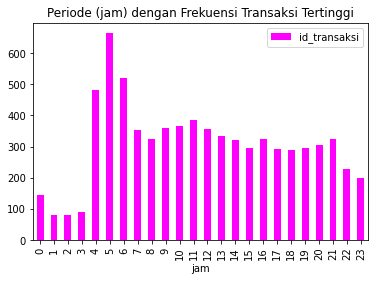

In [ ]:
# Periode/jam dengan frekuensi transaksi terbanyak (2021 dan 2022)
EDA_data['jam'] = EDA_data['tanggal'].dt.hour.to_frame()
EDA_data.groupby('jam')['id_transaksi'].count().to_frame().plot(kind='bar',
                                                                title ='Periode (jam) dengan Frekuensi Transaksi Tertinggi',
                                                                color='magenta')

plt.show()

In [ ]:
# Mengetahui tipe payment dari program dengan nominal donasi tertinggi
zakat_penghasilan = EDA_data[EDA_data['program'] == 'Zakat Penghasilan']
print(zakat_penghasilan ['payment'].value_counts())

bank_transfer    635
gopay             31
DANA              12
OVO               12
LINKAJA           11
SHOPEEPAY          5
echannel           4
credit_card        1
akulaku            1
ALFAMART           1
Name: payment, dtype: int64


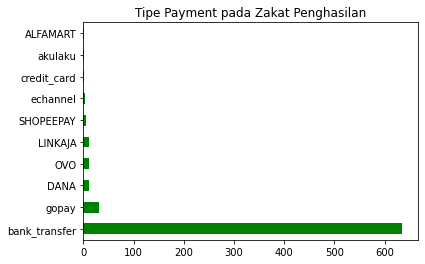

In [ ]:
zakat_penghasilan['payment'].value_counts().plot(kind='barh',
                                        title='Tipe Payment pada Zakat Penghasilan',
                                        color='green')
plt.show()

In [ ]:
zakat_penghasilan['tanggal'] = pd.to_datetime(zakat_penghasilan['tanggal'])

jam
11    52
9     51
12    50
10    46
13    45
16    41
14    39
8     37
18    36
7     35
15    31
21    30
20    30
17    30
6     29
22    28
19    27
5     24
4     22
23    11
3      6
0      6
2      4
1      3
Name: id_transaksi, dtype: int64


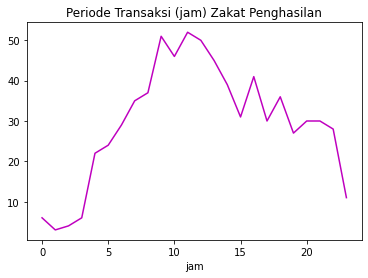

In [ ]:
# Mengetahui jam transaksi Zakat Penghasilan
zakat_penghasilan['jam'] = zakat_penghasilan['tanggal'].dt.hour
print(zakat_penghasilan.groupby('jam')['id_transaksi'].count().sort_values(ascending=False))
zakat_penghasilan.groupby('jam')['id_transaksi'].count().plot(kind='line',
                                                                title ='Periode Transaksi (jam) Zakat Penghasilan',
                                                                color='m')
plt.show()

Tanggal
1     63
29    59
25    59
28    49
2     39
24    36
27    35
26    35
30    30
4     26
5     24
7     24
6     23
31    19
8     19
3     18
11    18
12    17
22    17
9     14
10    13
23    12
15    11
13     9
18     9
21     8
20     8
17     8
16     6
14     3
19     2
Name: id_transaksi, dtype: int64


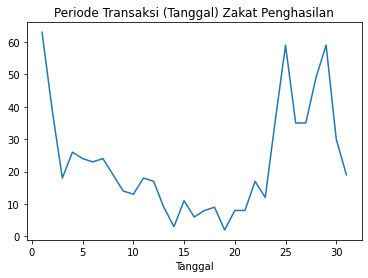

In [ ]:
# Mengetahui tanggal transaksi Zakat Penghasilan
zakat_penghasilan['Tanggal'] = zakat_penghasilan['tanggal'].dt.day
print(zakat_penghasilan.groupby('Tanggal')['id_transaksi'].count().sort_values(ascending=False))
zakat_penghasilan.groupby('Tanggal')['id_transaksi'].count().plot(kind='line',
                                                               title ='Periode Transaksi (Tanggal) Zakat Penghasilan')
plt.show()

In [ ]:
# Mengetahui tipe payment dari akad dengan nominal donasi tertinggi
panti_asuhan = EDA_data[EDA_data['akad'] == 'Panti Asuhan']
print(panti_asuhan['payment'].value_counts())

bank_transfer    850
gopay            128
SHOPEEPAY         40
DANA              33
OVO               16
LINKAJA           14
credit_card        7
echannel           6
Name: payment, dtype: int64


In [ ]:
panti_asuhan['tanggal'] = pd.to_datetime(panti_asuhan['tanggal'])

jam
5     98
11    78
9     71
15    64
13    63
10    62
12    60
8     55
14    51
20    48
17    48
18    46
21    45
7     44
4     43
16    42
19    41
6     39
22    36
23    27
0     12
1     11
3      6
2      4
Name: id_transaksi, dtype: int64


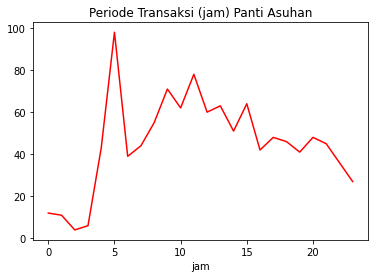

In [ ]:
# Mengetahui jam transaksi Panti Asuhan
panti_asuhan['jam'] = panti_asuhan['tanggal'].dt.hour
print(panti_asuhan.groupby('jam')['id_transaksi'].count().sort_values(ascending=False))
panti_asuhan.groupby('jam')['id_transaksi'].count().plot(kind='line',
                                                                title ='Periode Transaksi (jam) Panti Asuhan',
                                                                color='r')
plt.show()

## 3. RFM Analysis

### 3.1 Recency

In [ ]:
data['tanggal'].describe()

count                      7412
unique                     7393
top       2022-05-02 07:00:54.0
freq                          2
Name: tanggal, dtype: object

In [ ]:
data['tanggal'] = pd.to_datetime(data['tanggal'])

In [ ]:
# Hari terakhir donasi pada dataset 
data['tanggal'].max()

Timestamp('2022-08-01 10:41:37')

In [ ]:
# Melakukan grouping donatur dan periode terakhir donasi
recency_data = data.groupby(by='donor_id', as_index=False)['tanggal'].max()
recency_data.columns = ['donor_id','periode_terakhir_donasi']
recency_data.head()

,donor_id,periode_terakhir_donasi
0,G14409,2021-02-27 05:50:50
1,G14411,2021-01-05 05:32:07
2,G14412,2021-01-05 08:41:38
3,G14415,2021-02-06 07:21:09
4,G14423,2021-01-05 19:22:49


In [ ]:
recent_time = (data['tanggal'].max() + pd.Timedelta(days=1)).replace(hour = 23, minute = 59, second = 59)
print(recent_time)

2022-08-02 23:59:59


In [ ]:
recency_data['gap_time'] = (recent_time - recency_data['periode_terakhir_donasi'])
recency_data['recency'] = recency_data['gap_time'].dt.days
recency_data


,donor_id,periode_terakhir_donasi,gap_time,recency
0,G14409,2021-02-27 05:50:50,521 days 18:09:09,521
1,G14411,2021-01-05 05:32:07,574 days 18:27:52,574
2,G14412,2021-01-05 08:41:38,574 days 15:18:21,574
3,G14415,2021-02-06 07:21:09,542 days 16:38:50,542
4,G14423,2021-01-05 19:22:49,574 days 04:37:10,574
...,...,...,...,...
4571,G20666,2022-08-01 05:19:29,1 days 18:40:30,1
4572,G20667,2022-08-01 05:27:15,1 days 18:32:44,1
4573,G20668,2022-08-01 07:17:01,1 days 16:42:58,1
4574,G20671,2022-08-01 09:28:41,1 days 14:31:18,1


In [ ]:
# Drop kolom periode terakhir donasi dan gap_time karena sudah tidak diperlukan

recency_data.drop(['periode_terakhir_donasi','gap_time'], axis = 1, inplace = True)
recency_data.sort_values('recency', ascending=False)

,donor_id,recency
2,G14412,574
4,G14423,574
5,G14425,574
1,G14411,574
9,G14433,573
...,...,...
4571,G20666,1
4572,G20667,1
4573,G20668,1
4574,G20671,1


### 3.2 Frequency

In [ ]:
# Melakukan grouping donor_id dengan frekuensi transaksi

freq_data = data.groupby(by= 'donor_id', as_index=False)['id_transaksi'].count() 
freq_data = freq_data.rename(columns = {'id_transaksi':'frequency'})
freq_data.sort_values('frequency', ascending=False)

,donor_id,frequency
588,G15314,210
63,G14511,72
7,G14427,39
1810,G16987,39
1316,G16329,37
...,...,...
2091,G17343,1
435,G15092,1
434,G15089,1
2094,G17346,1


In [ ]:
# Merge dataframe recency dengan frequency
rec_freq = recency_data.merge(freq_data, on = 'donor_id')
rec_freq.head()

,donor_id,recency,frequency
0,G14409,521,3
1,G14411,574,1
2,G14412,574,1
3,G14415,542,2
4,G14423,574,1


### 3.3 Monetary

In [ ]:
# Melakukan grouping donor id berdasarkan nominal transaksi

nominal_data = data.groupby(by= 'donor_id', as_index=False)['nominal'].sum() 
nominal_data = nominal_data.rename(columns = {'nominal':'monetary'})
nominal_data.sort_values('monetary', ascending=False)

,donor_id,monetary
588,G15314,43528821
1413,G16471,14858374
3135,G18713,14500000
525,G15210,7695000
448,G15109,7315549
...,...,...
251,G14793,5000
295,G14864,5000
55,G14503,2000
417,G15064,2000


In [ ]:
# Merge dataframe rec_freq dengan monetary
rfm_df = rec_freq.merge(nominal_data, on = 'donor_id')
rfm_df.head()

,donor_id,recency,frequency,monetary
0,G14409,521,3,230000
1,G14411,574,1,20000
2,G14412,574,1,150000
3,G14415,542,2,231069
4,G14423,574,1,25000


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer



In [ ]:
a, b = 0, 1
x, y = rfm_df.recency.min(), rfm_df.recency.max()
rfm_df['recency_norm'] = (rfm_df.recency - x) / (y - x) * (b - a) + a

rfm_df

fig = px.histogram(rfm_df, x="recency_norm", title='Histogram of recency', color_discrete_sequence = ['red'])

fig.show()

In [ ]:
a, b = 0, 1
x, y = rfm_df.frequency.min(), rfm_df.frequency.max()
rfm_df['frequency_norm'] = (rfm_df.frequency - x) / (y - x) * (b - a) + a

rfm_df

fig = px.histogram(rfm_df, x="frequency", title='Histogram of frequency', color_discrete_sequence = ['green'])

fig.show()

In [ ]:
a, b = 0, 1
x, y = rfm_df.monetary.min(), rfm_df.monetary.max()
rfm_df['monetary_norm'] = (rfm_df.monetary - x) / (y - x) * (b - a) + a

rfm_df

fig = px.histogram(rfm_df, x="monetary", title='Histogram of monetary', color_discrete_sequence = ['blue'])

fig.show()

### 3.4 Log Scaling

In [ ]:
rfm_df['recency_log'] = np.log(rfm_df['recency'])

a, b = 0, 1
x, y = rfm_df.recency_log.min(), rfm_df.recency_log.max()
rfm_df['recency_lognorm'] = (rfm_df.recency_log - x) / (y - x) * (b - a) + a

rfm_df

fig = px.histogram(rfm_df, x="recency_lognorm", title='Histogram of recency', color_discrete_sequence = ['red'])

fig.show()

In [ ]:
rfm_df['frequency_log'] = np.log(rfm_df['frequency'])

a, b = 0, 1
x, y = rfm_df.frequency_log.min(), rfm_df.frequency_log.max()
rfm_df['frequency_lognorm'] = (rfm_df.frequency_log - x) / (y - x) * (b - a) + a

rfm_df

fig = px.histogram(rfm_df, x="frequency_lognorm", title='Histogram of Frequency', color_discrete_sequence = ['green'])

fig.show()

In [ ]:
rfm_df['monetary_log'] = np.log(rfm_df['monetary'])

a, b = 0, 1
x, y = rfm_df.monetary_log.min(), rfm_df.monetary_log.max()
rfm_df['monetary_lognorm'] = (rfm_df.monetary_log - x) / (y - x) * (b - a) + a

rfm_df

fig = px.histogram(rfm_df, x="monetary_lognorm", title='Histogram of Monetary', color_discrete_sequence = ['blue'])

fig.show()

## 4. K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

X = rfm_df[['recency_lognorm', 'frequency_lognorm', 'monetary_lognorm']]

inertia = [] 
clusters = []
silh_scores = [] 
silh_values = []

for k in range(1, 10):
  model = KMeans(n_clusters = k + 1, random_state = 0)
  fitted_model = model.fit(X)
  labels = fitted_model.labels_
  inertia.append(fitted_model.inertia_)
  silhouette_avg = silhouette_score(X, fitted_model.labels_, metric='euclidean')
  silh_scores.append(silhouette_avg)

  sample_silhouette_values = silhouette_samples(X, labels)

  silh_values.append(sample_silhouette_values)

  clusters.append(k + 1)

kmeans_result = pd.DataFrame(list(zip(clusters, inertia, silh_scores)), columns =['clusters', 'inertia', 'silhouette_scores'])

print(kmeans_result)

   clusters     inertia  silhouette_scores
0         2  156.255882           0.537404
1         3  116.471965           0.336647
2         4   87.646617           0.368860
3         5   68.310287           0.391351
4         6   60.138476           0.394284
5         7   53.445228           0.363906
6         8   47.328515           0.356509
7         9   43.352233           0.363044
8        10   40.295985           0.367243


In [ ]:
fig = px.line(x=kmeans_result['clusters'], y= kmeans_result['inertia'], markers=True)
fig.show()

In [ ]:
fig = (px.line(x=kmeans_result['clusters'], y= kmeans_result['silhouette_scores'])).update_traces(mode='lines+markers')
fig.show()

In [ ]:
kmeans_result['diff_inertia'] = kmeans_result['inertia'].shift(1) - kmeans_result['inertia']
kmeans_result['diff_inertia_2'] = kmeans_result['diff_inertia'].shift(1) - kmeans_result['diff_inertia']

kmeans_result

,clusters,inertia,silhouette_scores,diff_inertia,diff_inertia_2
0,2,156.255882,0.537404,NaN,NaN
1,3,116.471965,0.336647,39.783916,NaN
2,4,87.646617,0.368860,28.825348,10.958569
3,5,68.310287,0.391351,19.336330,9.489018
4,6,60.138476,0.394284,8.171811,11.164518
5,7,53.445228,0.363906,6.693248,1.478563
6,8,47.328515,0.356509,6.116713,0.576535
7,9,43.352233,0.363044,3.976282,2.140431
8,10,40.295985,0.367243,3.056248,0.920035


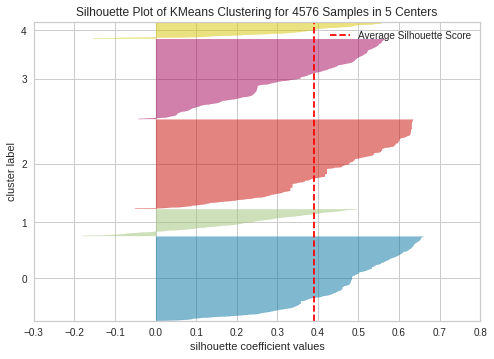

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

model_kmeans = KMeans(n_clusters = 5, random_state = 0)
model_kmeans.fit_transform(X[['recency_lognorm', 'frequency_lognorm', 'monetary_lognorm']])

X['cluster'] = model_kmeans.labels_
X["cluster"] = X["cluster"].astype(str)

visualizer = SilhouetteVisualizer(model_kmeans, colors='yellowbrick')

visualizer.fit(X[['recency_lognorm', 'frequency_lognorm', 'monetary_lognorm']])        # Fit the data to the visualizer
visualizer.show()

In [ ]:
rfm_df['cluster'] = model_kmeans.fit_predict(rfm_df[['recency_lognorm', 'frequency_lognorm', 'monetary_lognorm']])

rfm_df['cluster'] = rfm_df['cluster'].astype(int)

rfm_df

,donor_id,recency,frequency,monetary,recency_norm,frequency_norm,monetary_norm,recency_log,recency_lognorm,frequency_log,frequency_lognorm,monetary_log,monetary_lognorm,cluster
0,G14409,521,3,230000,0.907504,0.009569,0.005239,6.255750,0.98475,1.098612,0.205459,12.345835,0.476068,3
1,G14411,574,1,20000,1.000000,0.000000,0.000414,6.352629,1.00000,0.000000,0.000000,9.903488,0.232009,0
2,G14412,574,1,150000,1.000000,0.000000,0.003401,6.352629,1.00000,0.000000,0.000000,11.918391,0.433354,3
3,G14415,542,2,231069,0.944154,0.004785,0.005264,6.295266,0.99097,0.693147,0.129630,12.350472,0.476531,3
4,G14423,574,1,25000,1.000000,0.000000,0.000529,6.352629,1.00000,0.000000,0.000000,10.126631,0.254308,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,G20666,1,1,20000,0.000000,0.000000,0.000414,0.000000,0.00000,0.000000,0.000000,9.903488,0.232009,4
4572,G20667,1,1,50000,0.000000,0.000000,0.001104,0.000000,0.00000,0.000000,0.000000,10.819778,0.323572,4
4573,G20668,1,1,20000,0.000000,0.000000,0.000414,0.000000,0.00000,0.000000,0.000000,9.903488,0.232009,4
4574,G20671,1,1,300000,0.000000,0.000000,0.006847,0.000000,0.00000,0.000000,0.000000,12.611538,0.502619,4


In [ ]:
centroid = model_kmeans.cluster_centers_.tolist()
keys = [0,1,2,3,4]

centroid_df = pd.DataFrame.from_dict(dict(zip(keys, centroid))).T

cols = {'index': 'cluster',
        0: 'recency_centroid',
        1: 'frequency_centroid',
        2: 'monetary_centroid'}

centroid_df.reset_index(inplace = True)
centroid_df.rename(columns = cols, inplace = True)

centroid_df

,cluster,recency_centroid,frequency_centroid,monetary_centroid
0,0,0.889438,0.008623,0.273072
1,1,0.758500,0.264496,0.566404
2,2,0.710491,0.010168,0.390587
3,3,0.925296,0.019306,0.469764
4,4,0.297058,0.138337,0.465451


In [ ]:
rfm_df = pd.merge(rfm_df, centroid_df, how = 'inner', left_on = 'cluster', right_on = 'cluster')
rfm_df

,donor_id,recency,frequency,monetary,recency_norm,frequency_norm,monetary_norm,recency_log,recency_lognorm,frequency_log,frequency_lognorm,monetary_log,monetary_lognorm,cluster,recency_centroid,frequency_centroid,monetary_centroid
0,G14409,521,3,230000,0.907504,0.009569,0.005239,6.255750,0.984750,1.098612,0.205459,12.345835,0.476068,3,0.925296,0.019306,0.469764
1,G14412,574,1,150000,1.000000,0.000000,0.003401,6.352629,1.000000,0.000000,0.000000,11.918391,0.433354,3,0.925296,0.019306,0.469764
2,G14415,542,2,231069,0.944154,0.004785,0.005264,6.295266,0.990970,0.693147,0.129630,12.350472,0.476531,3,0.925296,0.019306,0.469764
3,G14425,574,1,100140,1.000000,0.000000,0.002256,6.352629,1.000000,0.000000,0.000000,11.514324,0.392977,3,0.925296,0.019306,0.469764
4,G14428,573,1,100000,0.998255,0.000000,0.002252,6.350886,0.999726,0.000000,0.000000,11.512925,0.392837,3,0.925296,0.019306,0.469764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,G20525,23,1,150000,0.038394,0.000000,0.003401,3.135494,0.493574,0.000000,0.000000,11.918391,0.433354,2,0.710491,0.010168,0.390587
4572,G20528,21,1,20000,0.034904,0.000000,0.000414,3.044522,0.479254,0.000000,0.000000,9.903488,0.232009,2,0.710491,0.010168,0.390587
4573,G20533,18,1,20000,0.029668,0.000000,0.000414,2.890372,0.454988,0.000000,0.000000,9.903488,0.232009,2,0.710491,0.010168,0.390587
4574,G20539,18,1,20000,0.029668,0.000000,0.000414,2.890372,0.454988,0.000000,0.000000,9.903488,0.232009,2,0.710491,0.010168,0.390587


In [ ]:
px.scatter_3d(data_frame = rfm_df, x='recency', y='frequency', z='monetary', color = 'cluster',
             title='3D Scatter plot for KMeans Clusters')

In [ ]:
px.scatter_3d(data_frame = rfm_df, x='recency_lognorm', y='frequency_lognorm', z='monetary_lognorm', color = 'cluster',
             title='3D Scatter plot for KMeans Clusters')

In [ ]:
rfm_group = rfm_df.groupby('cluster', as_index = False).agg(recency_min = ('recency', 'min'), recency_mean = ('recency', 'mean'), recency_max = ('recency', 'max'),
                                                                 frequency_min = ('frequency', 'min'), frequency_mean = ('frequency', 'mean'), frequency_max = ('frequency', 'max'), 
                                                                 monetary_min = ('monetary', 'min'), monetary_mean = ('monetary', 'mean'), monetary_max = ('monetary', 'max'),
                                                                 count_rfm = ('monetary', 'count'))

rfm_group = rfm_group.sort_values(by = ['recency_min', 'recency_mean', 'recency_max', 'frequency_min', 'frequency_mean', 'frequency_max', 'monetary_min', 'monetary_mean', 'monetary_max'], ascending = [True, True, True, False, False, False, False, False, False])
rfm_group

,cluster,recency_min,recency_mean,recency_max,frequency_min,frequency_mean,frequency_max,monetary_min,monetary_mean,monetary_max,count_rfm
4,4,1,8.352697,29,1,3.099585,39,20000,5.710678e+05,14500000,241
1,1,12,160.937198,530,1,5.673913,210,80000,1.044589e+06,43528821,414
2,2,18,95.139855,197,1,1.078986,3,20000,1.446904e+05,2000000,1380
0,0,108,307.650038,574,1,1.070606,4,1962,3.367216e+04,85000,1303
3,3,113,378.631664,574,1,1.156704,4,70000,3.167592e+05,2798000,1238


In [ ]:
rfm_group.sort_values(by=['cluster'])

,cluster,recency_min,recency_mean,recency_max,frequency_min,frequency_mean,frequency_max,monetary_min,monetary_mean,monetary_max,count_rfm
0,0,108,307.650038,574,1,1.070606,4,1962,3.367216e+04,85000,1303
1,1,12,160.937198,530,1,5.673913,210,80000,1.044589e+06,43528821,414
2,2,18,95.139855,197,1,1.078986,3,20000,1.446904e+05,2000000,1380
3,3,113,378.631664,574,1,1.156704,4,70000,3.167592e+05,2798000,1238
4,4,1,8.352697,29,1,3.099585,39,20000,5.710678e+05,14500000,241


In [ ]:
rfm_df = pd.merge(rfm_df, rfm_group, how = 'inner', left_on = 'cluster', right_on = 'cluster')
rfm_df

,donor_id,recency,frequency,monetary,recency_norm,frequency_norm,monetary_norm,recency_log,recency_lognorm,frequency_log,...,recency_min,recency_mean,recency_max,frequency_min,frequency_mean,frequency_max,monetary_min,monetary_mean,monetary_max,count_rfm
0,G14409,521,3,230000,0.907504,0.009569,0.005239,6.255750,0.984750,1.098612,...,113,378.631664,574,1,1.156704,4,70000,316759.227787,2798000,1238
1,G14412,574,1,150000,1.000000,0.000000,0.003401,6.352629,1.000000,0.000000,...,113,378.631664,574,1,1.156704,4,70000,316759.227787,2798000,1238
2,G14415,542,2,231069,0.944154,0.004785,0.005264,6.295266,0.990970,0.693147,...,113,378.631664,574,1,1.156704,4,70000,316759.227787,2798000,1238
3,G14425,574,1,100140,1.000000,0.000000,0.002256,6.352629,1.000000,0.000000,...,113,378.631664,574,1,1.156704,4,70000,316759.227787,2798000,1238
4,G14428,573,1,100000,0.998255,0.000000,0.002252,6.350886,0.999726,0.000000,...,113,378.631664,574,1,1.156704,4,70000,316759.227787,2798000,1238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,G20525,23,1,150000,0.038394,0.000000,0.003401,3.135494,0.493574,0.000000,...,18,95.139855,197,1,1.078986,3,20000,144690.368116,2000000,1380
4572,G20528,21,1,20000,0.034904,0.000000,0.000414,3.044522,0.479254,0.000000,...,18,95.139855,197,1,1.078986,3,20000,144690.368116,2000000,1380
4573,G20533,18,1,20000,0.029668,0.000000,0.000414,2.890372,0.454988,0.000000,...,18,95.139855,197,1,1.078986,3,20000,144690.368116,2000000,1380
4574,G20539,18,1,20000,0.029668,0.000000,0.000414,2.890372,0.454988,0.000000,...,18,95.139855,197,1,1.078986,3,20000,144690.368116,2000000,1380


In [ ]:
rfm_df.groupby('cluster').agg({'donor_id':'count'}).sort_values("donor_id",ascending=False)

,donor_id
cluster,
2,1380
0,1303
3,1238
1,414
4,241


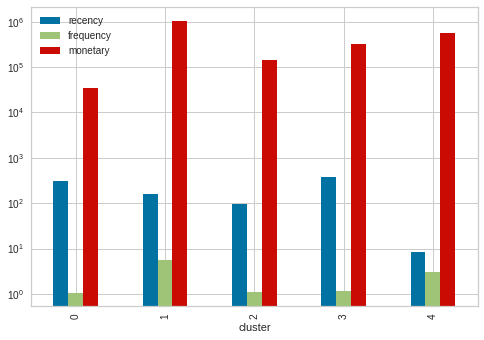

In [ ]:
grouped_df = rfm_df[['recency', 'frequency', 'monetary','cluster']].groupby('cluster').mean()
grouped_df.plot(kind='bar',logy=True)    
plt.show()

Dari grafik tersebut dapat dilihat karakteristik masing-masing cluster berdasarkan RFM-nya. 
Prioritas pengurutan lebih ditekankan pada monetary dan frequency sehingga diperoleh segmentasi customer sebagai berikut.

Best customers = cluster 1
Loyal customers = cluster 4
Almost lost = cluster 2
Lost customers = 3
Lost cheap customers = 0

In [ ]:
#Drop kolom yang tidak dibutuhkan 
rfm_df.drop(['recency_norm','frequency_norm','monetary_norm','recency_log','recency_lognorm',
             'frequency_log','frequency_lognorm','monetary_log','monetary_lognorm',
             'recency_centroid','frequency_centroid','monetary_centroid'], axis=1, inplace = True)

In [ ]:
rfm_df.drop(['recency_min','recency_mean','recency_max','frequency_min','frequency_mean',
             'frequency_max','monetary_min','monetary_mean','monetary_max'], axis=1, inplace = True)

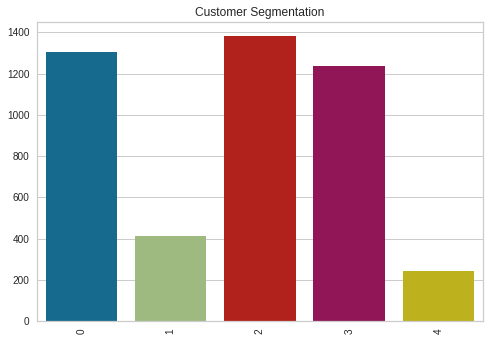

In [ ]:
plot = rfm_df['cluster'].value_counts()
plt.figure()

sns.barplot(x = plot.index, y= plot.values)
plt.xticks(rotation=90)
plt.title('Customer Segmentation')
plt.show()

## 5. Profiling

### 5.1 Best Customers

In [ ]:
best = rfm_df[rfm_df['cluster'] == 1]
best

,donor_id,recency,frequency,monetary,cluster,count_rfm
2541,G14426,182,3,330000,1,414
2542,G14427,530,39,780000,1,414
2543,G14437,101,7,2050000,1,414
2544,G14459,341,3,700000,1,414
2545,G14463,95,3,370000,1,414
...,...,...,...,...,...,...
2950,G20277,62,2,600000,1,414
2951,G20368,63,4,750000,1,414
2952,G20371,25,4,800000,1,414
2953,G20393,58,3,840000,1,414


In [ ]:
best.describe()

,recency,frequency,monetary,cluster,count_rfm
count,414.000000,414.000000,4.140000e+02,414.0,414.0
mean,160.937198,5.673913,1.044589e+06,1.0,414.0
std,115.974765,11.564011,2.438847e+06,0.0,0.0
min,12.000000,1.000000,8.000000e+04,1.0,414.0
25%,92.000000,3.000000,2.800000e+05,1.0,414.0
50%,116.500000,4.000000,5.560000e+05,1.0,414.0
75%,209.750000,5.000000,1.146250e+06,1.0,414.0
max,530.000000,210.000000,4.352882e+07,1.0,414.0


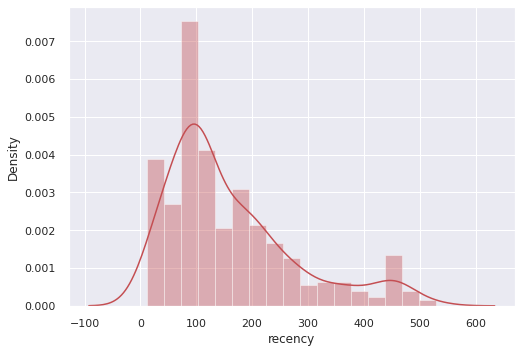

In [ ]:
# Persebaran recency pada cluster 1 (best customers)
sns.set()
sns.distplot(best.recency, color='r');

In [ ]:
best['recency'].value_counts().to_frame()

,recency
95,19
92,16
93,15
116,10
109,8
...,...
349,1
319,1
112,1
475,1


In [ ]:
best[best['recency'] > 200]

,donor_id,recency,frequency,monetary,cluster,count_rfm
2542,G14427,530,39,780000,1,414
2544,G14459,341,3,700000,1,414
2548,G14491,363,3,2450000,1,414
2549,G14511,469,72,388751,1,414
2551,G14531,431,11,1255000,1,414
...,...,...,...,...,...,...
2800,G17329,214,3,300000,1,414
2816,G17444,236,2,2000000,1,414
2820,G17467,207,3,150000,1,414
2825,G17551,203,4,81685,1,414


Pada grafik dapat dilihat bahwa customer pada kelompok ini lebih banyak melakukan donasi pada periode 90 hingga 100 hari dari tanggal 02 Agustus 2022. Meskipun recency terbesar bisa dikatakan cukup jauh yaitu 530 hari, namun jika diamati customer yang melakukan donasi di atas 200 hari hingga 530 hari jumlahya semakin menurun yaitu 111 customer dari 414 customer.

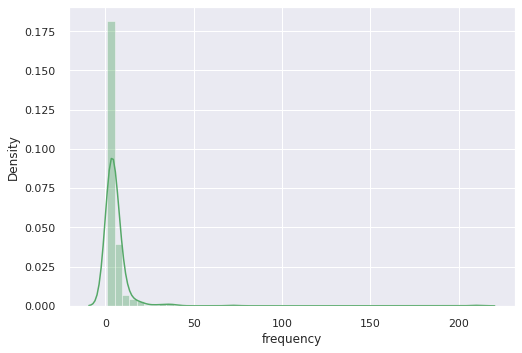

In [ ]:
# Persebaran frequency pada cluster 1 (best customers)
sns.set()
sns.distplot(best.frequency, color='g');

In [ ]:
best['frequency'].value_counts().to_frame()

,frequency
3,100
2,84
4,79
5,50
6,22
7,19
9,14
8,13
10,5
11,4


In [ ]:
percent_freq_best = round((best['frequency'].value_counts())*100/414, 2).to_frame()
percent_freq_best

,frequency
3,24.15
2,20.29
4,19.08
5,12.08
6,5.31
7,4.59
9,3.38
8,3.14
10,1.21
11,0.97


In [ ]:
# Prosentasi customers berdonasi lebih dari 10 kali
round((best[best['frequency']>10].value_counts())*100/414,2).sum()

6.48

Pada kelompok best customers, donatur paling banyak melakukan donasi sebanyak 2-3 kali dan jumlahnya cenderung semakin sedikit pada frekuensi donasi di atas 10 kali yaitu 6,48 % dari 414 customers

Jumlah Donasi Best Customers = Rp 432459723


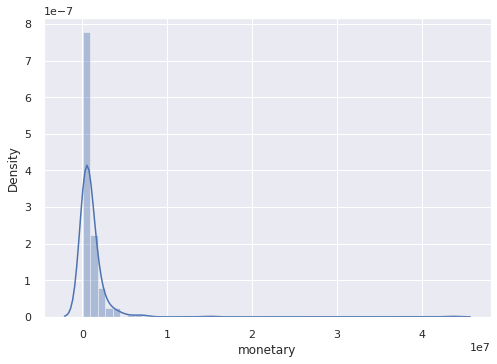

In [ ]:
# Persebaran monetary pada cluster 1 (best customers)
sns.set()
sns.distplot(best.monetary, color='b');
jumlah_donasi_best = best['monetary'].sum()
print(f"Jumlah Donasi Best Customers = Rp {jumlah_donasi_best}")

In [ ]:
best['monetary'].value_counts().to_frame()

,monetary
300000,17
500000,13
350000,12
1000000,12
150000,11
...,...
399000,1
273000,1
1380000,1
497500,1


In [ ]:
best[best['monetary']>5000000].sum()

donor_id     G14711G14794G15109G15314G16127G16436G16471G16952
recency                                                  1560
frequency                                                 292
monetary                                             96032744
cluster                                                     8
count_rfm                                                3312
dtype: object

In [ ]:
best[best['monetary']<=5000000].sum()

donor_id     G14426G14427G14437G14459G14463G14468G14480G144...
recency                                                  65068
frequency                                                 2057
monetary                                             336426979
cluster                                                    406
count_rfm                                               168084
dtype: object

Pada kelompok best customers, total nominal donasi yang diperoleh sekitar Rp 432.459.723 jumlah yang cukup besar dari total donasi keseluruhan Rp 1,6 M dari periode 5 Januari 2021 - 01 Agustus 2022 atau hampir 1/3 total donasi berasal dari transaksi cluster ini. 

Rentang nominal donasi pada cluster ini cukup besar yaitu dari Rp 80.000 hingga Rp 43.528.820.

Sebagian besar donatur melakukan donasi dengan nominal kurang dari 5 juta (sebanyak 2057 transaksi) dengan total nominal sebesar Rp 336.426.979 dan sisanya meskipun hanya terdapat 292 transaksi namun menghasilkan nominal yang cukup besar pula, yaitu Rp 96.032.744

Dengan karakteristik tersebut maka kelompok ini sangat cocok dijadikan registered member.

### 5.2 Loyal Customers

In [ ]:
loyal = rfm_df[rfm_df['cluster'] == 4]
loyal.sort_values(by='monetary', ascending = False)

,donor_id,recency,frequency,monetary,cluster,count_rfm
3049,G18713,4,17,14500000,4,241
2968,G15210,3,16,7695000,4,241
3001,G17039,6,13,7046750,4,241
3016,G17793,1,7,4250000,4,241
2955,G14441,11,7,3700000,4,241
...,...,...,...,...,...,...
3158,G20620,5,1,20000,4,241
3113,G20563,11,1,20000,4,241
3174,G20645,4,1,20000,4,241
3111,G20561,11,1,20000,4,241


In [ ]:
loyal.describe()

,recency,frequency,monetary,cluster,count_rfm
count,241.000000,241.000000,2.410000e+02,241.0,241.0
mean,8.352697,3.099585,5.710678e+05,4.0,241.0
std,5.592041,3.862000,1.275721e+06,0.0,0.0
min,1.000000,1.000000,2.000000e+04,4.0,241.0
25%,4.000000,1.000000,7.000000e+04,4.0,241.0
50%,7.000000,2.000000,2.000000e+05,4.0,241.0
75%,11.000000,4.000000,6.000000e+05,4.0,241.0
max,29.000000,39.000000,1.450000e+07,4.0,241.0


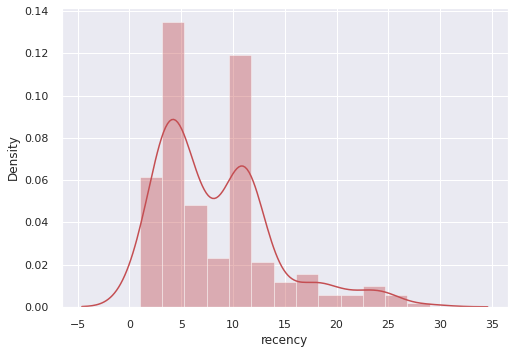

In [ ]:
# Persebaran recency pada cluster 4 (loyal customers)
sns.set()
sns.distplot(loyal.recency, color='r');

In [ ]:
loyal['recency'].value_counts().to_frame()

,recency
11,58
4,57
6,14
3,14
5,13
8,11
7,11
1,10
2,8
18,8


Pada kelompok loyal customers tidak ada yang melakukan donasi lebih dari 30 hari dari tanggal cut off yaitu 02 Agustus 2022. Periode donasi cukup bervariasi mulai dari 1 hari hingga 29 hari. Donatur paling banyak melakukan donasi dalam periode 4 hari dan 11 hari dari tanggal cut off, serta jumlahnya cenderung semakin sedikit saat mendekati angka 20 an.

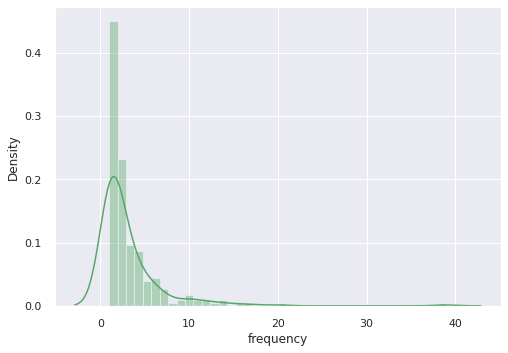

In [ ]:
# Persebaran frequency pada cluster 4 (loyal customers)
sns.set()
sns.distplot(loyal.frequency, color='g');

In [ ]:
loyal['frequency'].value_counts().to_frame()

,frequency
1,103
2,53
3,22
4,20
6,10
5,9
7,6
10,4
12,2
14,2


In [ ]:
percent_freq_loyal = round((loyal['frequency'].value_counts())*100/241, 2).to_frame()
percent_freq_loyal

,frequency
1,42.74
2,21.99
3,9.13
4,8.30
6,4.15
5,3.73
7,2.49
10,1.66
12,0.83
14,0.83


Pada grafik frequency dapat dilihat bahwa sekitar 42,74% donatur hanya melakukan donasi secara one time saja dan cenderung makin sedikit yang melakukan donasi lebih dari 10 kali. 

Jumlah Donasi Loyal Customers = Rp 137627328


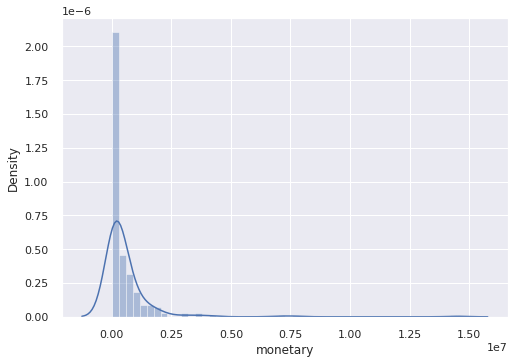

In [ ]:
# Persebaran monetary pada cluster 4 (loyal customers)
sns.set()
sns.distplot(loyal.monetary, color='b');
jumlah_donasi_loyal = loyal['monetary'].sum()
print(f"Jumlah Donasi Loyal Customers = Rp {jumlah_donasi_loyal}")

In [ ]:
loyal['monetary'].value_counts().to_frame()

,monetary
20000,24
100000,24
50000,21
200000,14
250000,10
...,...
1280000,1
1580000,1
450000,1
90000,1


In [ ]:
loyal[loyal['monetary'] <=2500000]

,donor_id,recency,frequency,monetary,cluster,count_rfm
2956,G14518,11,3,1250000,4,241
2958,G14683,11,2,70000,4,241
2959,G14790,4,2,650000,4,241
2960,G14819,4,2,800000,4,241
2961,G15026,3,20,395000,4,241
...,...,...,...,...,...,...
3191,G20666,1,1,20000,4,241
3192,G20667,1,1,50000,4,241
3193,G20668,1,1,20000,4,241
3194,G20671,1,1,300000,4,241


In [ ]:
loyal[loyal['monetary'] <=2500000].sum()

donor_id     G14518G14683G14790G14819G15026G15042G15047G150...
recency                                                   1970
frequency                                                  666
monetary                                              90806078
cluster                                                    932
count_rfm                                                56153
dtype: object

In [ ]:
loyal[loyal['monetary'] > 2500000]

,donor_id,recency,frequency,monetary,cluster,count_rfm
2955,G14441,11,7,3700000,4,241
2957,G14672,2,14,3629500,4,241
2968,G15210,3,16,7695000,4,241
3001,G17039,6,13,7046750,4,241
3016,G17793,1,7,4250000,4,241
3018,G17913,4,4,3000000,4,241
3036,G18565,12,3,3000000,4,241
3049,G18713,4,17,14500000,4,241


In [ ]:
loyal[loyal['monetary'] > 2500000].sum()

donor_id     G14441G14672G15210G17039G17793G17913G18565G18713
recency                                                    43
frequency                                                  81
monetary                                             46821250
cluster                                                    32
count_rfm                                                1928
dtype: object

Pada cluster ini perbedaan nominal donasi rentangnya cukup besar, yaitu Rp 20.000 hingga Rp 14.500.000. Pada grafik terlihat donatur lebih banyak melakukan donasi pada kisaran Rp 2.500.000, yaitu sebanyak 233 donatur dengan transaksi 666 kali. Dari transaksi ini dihasilkan Rp 90.806.078

Sementara untuk nominal di atas 2.500.000 hanya terdapat 8 customers dengan jumlah transaksi 81 kali, namun nominal yang dihasilkan cukup besar yaitu Rp 46.821.250

Meskipun dari aspek frequency dan monetary masih di bawah best customers, namun beberapa anggota pada cluster ini memberikan nominal yang cukup tinggi dalam berdonasi sehingga sangat cocok jika dijadikan registered member, apalagi recency pada kelompok ini tidak ada yang di atas 30 hari.